In [38]:
# Import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import normalize, to_categorical

In [33]:
hh_xsec = 12.36 # fb
qcd_xsec = 441866.0 # fb

hh_effLumi = 33034 # fb-1
qcd_effLumi = 1.36 # fb-1
totalLumi_HLLHC = 3000 # fb-1

#L = N/sig --> L_qcd / L_hh is the lumi-scale we need
lumiScale_hh_to_qcd = qcd_effLumi/hh_effLumi
print(lumiScale_hh_to_qcd)

4.116970394139372e-05


In [34]:
def makeEqualSamplesWithUserVariables(signal_raw, bkg_raw, userVariables, nEventsForXGB):
    """function to return 4 dataframes containing user-specified variables and number of events: 1 signal for training, 1 bkg for training, 1 signal for plotting, 1 bkg for plotting"""
    
    # *** 0. Reduce dataframes to only desired variables
    signal_reduced  = signal_raw[userVariables]
    bkg_reduced     = bkg_raw[userVariables]
    signal_labels   = signal_raw[ ['isSignal'] ]
    bkg_labels      = bkg_raw[ ['isSignal'] ]

    # *** 1. Take first nEventsForXGB events for passing to XGB 
    signal_reducedForXGB  = signal_reduced[:nEventsForXGB]
    bkg_reducedForXGB     = bkg_reduced[:nEventsForXGB]
    signal_labelsForXGB   = signal_labels[:nEventsForXGB]
    bkg_labelsForXGB      = bkg_labels[:nEventsForXGB]

    # *** 2. Combine bkg+signal for passing to XGB 
    all_reducedForXGB  = signal_reducedForXGB.append(bkg_reducedForXGB)
    all_labelsForXGB   = signal_labelsForXGB.append(bkg_labelsForXGB)

    
    # ** 3. Use additional events for unambiguous testing 
    signal_reducedForPlots  = signal_reduced[nEventsForXGB:len(bkg_reduced)]
    bkg_reducedForPlots     = bkg_reduced[nEventsForXGB:len(bkg_reduced)]
    signal_labelsForPlots   = signal_labels[nEventsForXGB:len(bkg_reduced)]
    bkg_labelsForPlots      = bkg_labels[nEventsForXGB:len(bkg_reduced)]

    # *** 4. Sanity check
    print(len(all_reducedForXGB), 'rows of data with ', len(all_labelsForXGB), 'labels [XGB]')
    print(len(signal_reducedForPlots), 'rows of signal data with ', len(bkg_labelsForPlots), 'rows of background [Plots]')

    
    return all_reducedForXGB, all_labelsForXGB, signal_reducedForPlots, signal_labelsForPlots, bkg_reducedForPlots, bkg_labelsForPlots

In [35]:
#*** 1. Import BDT model and check stuff
# *** 0. Import Dataset
qcd_raw = pd.read_csv('../samples_500k/qcd_outputDataForLearning.csv')
qcd_raw['isSignal'] = 0
hh_raw = pd.read_csv('../samples_500k/dihiggs_outputDataForLearning.csv')
hh_raw['isSignal'] = 1


# *** 5. Make mix of dihiggs and QCD for top-10 optimal variables
nEventsToTrain = 10000
variables_top10 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT']
top10_data, top10_labels, hh_top10_data, hh_top10_labels, qcd_top10_data, qcd_top10_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_top10, nEventsToTrain) 


20000 rows of data with  20000 labels [XGB]
19176 rows of signal data with  19176 rows of background [Plots]


In [36]:
top10_data.head()
top10_data.shape

(20000, 10)

In [ ]:
# Run the training for 3 different network architectures: (10-5-2) (10-10-2) (10-20-2)

# Plot the loss function over iterations
num_hidden_nodes = [5, 10, 20]
loss_plot = {5: [], 10: [], 20: []}
weights1 = {5: None, 10: None, 20: None}
weights2 = {5: None, 10: None, 20: None}
num_iters = 2000

plt.figure(figsize=(12,8))
for hidden_nodes in num_hidden_nodes:
    weights1[hidden_nodes], weights2[hidden_nodes] = create_train_model(hidden_nodes, num_iters)
    plt.plot(range(num_iters), loss_plot[hidden_nodes], label="nn: 10-%d-2" % hidden_nodes)
    
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)

In [39]:
# *** 2. Normalize data inputs
top10_data = normalize(top10_data, axis=1)
hh_top10_data = normalize(hh_top10_data, axis=1)
qcd_top10_data = normalize(qcd_top10_data, axis=1)

In [43]:
# *** 3. Define NN model and train
model = Sequential()
model.add(Dense(80, input_dim=10, activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(20, input_dim=10, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(top10_data, top10_labels, epochs=20)

#score = model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/20
20000/20000 [==============================] - 1s 45us/step - loss: 0.6491 - accuracy: 0.6271
Epoch 2/20
20000/20000 [==============================] - 1s 40us/step - loss: 0.6223 - accuracy: 0.6445
Epoch 3/20
20000/20000 [==============================] - 1s 41us/step - loss: 0.6158 - accuracy: 0.6527
Epoch 4/20
20000/20000 [==============================] - 1s 40us/step - loss: 0.6097 - accuracy: 0.6581
Epoch 5/20
20000/20000 [==============================] - 1s 40us/step - loss: 0.6071 - accuracy: 0.6633
Epoch 6/20
20000/20000 [==============================] - 1s 41us/step - loss: 0.6026 - accuracy: 0.6688
Epoch 7/20
20000/20000 [==============================] - 1s 41us/step - loss: 0.5997 - accuracy: 0.6732
Epoch 8/20
20000/20000 [==============================] - 1s 42us/step - loss: 0.5961 - accuracy: 0.6746
Epoch 9/20
20000/20000 [==============================] - 1s 44us/step - loss: 0.5927 - accuracy: 0.6801
Epoch 10/20
20000/20000 [==============================

In [44]:
score_hh = model.evaluate(hh_top10_data, hh_top10_labels)
score_qcd = model.evaluate(qcd_top10_data, qcd_top10_labels)
print(score_hh, score_qcd)

19176/19176 [==============================] - 0s 19us/step
[0.5571982688738696, 0.7406654357910156] [0.5585845160792656, 0.684762179851532]


In [45]:
pred_hh = model.predict(hh_top10_data)
pred_qcd = model.predict(qcd_top10_data)

In [46]:

def compareManyHistograms( _dict, _labels, _nPlot, _title, _xtitle, _xMin, _xMax, _nBins, _normed=False, _savePlot=False):
       
    if len(_dict.keys()) < len(_labels):
        print ("!!! Unequal number of arrays and labels. Learn to count better.")
        return 0
    
    plt.figure(_nPlot)
    if _normed:
        plt.title(_title + ' (Normalized)')
    else:
        plt.title(_title)
    plt.xlabel(_xtitle)
    plt.ylabel('N_events')
    _bins = np.linspace(_xMin, _xMax, _nBins)
   
    y_max = 0
    for iLabel in _labels:
        plt.hist(_dict[iLabel], _bins, alpha=0.5, density=_normed, label= iLabel+' Events')
        
        # get values of histgoram to find greatest y
        #_y, _x, _ = plt.hist(_dict[iLabel])
        #if (_y.max() > y_max):
        #    y_max = _y.max()
    
    # set max y-value of histogram so there's room for legend
    axes = plt.gca()
    axes.set_ylim([0,4000])
    #plt.ylim([0,1.2*y_max])
    
    #draw legend
    plt.legend(loc='upper left')
    #plt.text(.1, .1, s1)
    
    # store figure copy for later saving
    fig = plt.gcf()
    
    # draw interactively
    plt.show()
    
    #save an image file
    if(_savePlot):
        _scope    = _title.split(' ')[0].lower()
        _variable = _xtitle.lstrip('Jet Pair').replace(' ','').replace('[GeV]','').replace('(','_').replace(')','')
        _filename  = _scope + '_' + _variable
        if _normed:
            _filename = _filename + '_norm'
        fig.savefig( _filename+'.png', bbox_inches='tight' )
    
    
    return

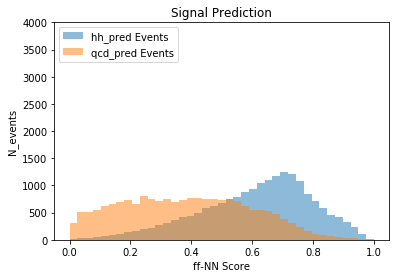

In [47]:
_nBins = 40
predictionResults = {'hh_pred':pred_hh, 'qcd_pred':pred_qcd}
compareManyHistograms( predictionResults, ['hh_pred', 'qcd_pred'], 2, 'Signal Prediction', 'ff-NN Score', 0, 1, _nBins, _savePlot=False )


In [48]:
def returnBestCutValue( _variable, _signal, _background, _method='S/sqrt(B)', _minBackground=500):
    """find best cut according to user-specified significance metric"""
    
    _bestSignificance = -1
    _bestCutValue = -1
    _massWidth = 30 #GeV
    _nTotalSignal =len(_signal) 
    _nTotalBackground =len(_background) 
    _cuts = []
    _sortedSignal = np.sort(_signal )
    _sortedBackground = np.sort(_background )

    print(_nTotalSignal, _nTotalBackground)
    _minVal = min( min(_sortedSignal), min(_sortedBackground) )
    _maxVal = max( max(_sortedSignal), max(_sortedBackground) )
    
    if 'mass' in _variable:
        _stepSize = 0.05 if 'mass' not in _variable else 5
        _cuts = list(range(_minVal, _maxVal, _stepSize))
    else:
        _cuts = np.linspace(_minVal, _maxVal, 100)
    
    #print(_minVal, _maxVal)

    for iCutValue in _cuts:
        _nSignal = sum( value > iCutValue for value in _signal)*lumiScale_hh_to_qcd*totalLumi_HLLHC
        _nBackground = sum( value > iCutValue for value in _background)*totalLumi_HLLHC
        
        # safety check to avoid division by 0
        if _nBackground < _minBackground: # 500 is semi-random choice.. it's where one series started to oscillate
            #print("continued on {0}".format(iCutValue))
            continue
        
        #if _method == 'S/sqrt(B)':
        #    print(_nSignal, _nBackground, iCutValue, (_nSignal / np.sqrt(_nBackground)), (_nSignal / np.sqrt(_nSignal + _nBackground)))
        
        if _method == 'S/B' and (_nSignal / _nBackground) > _bestSignificance:
            _bestSignificance = (_nSignal / _nBackground)
            _bestCutValue = iCutValue
        elif _method == 'S/sqrt(B)' and (_nSignal / np.sqrt(_nBackground)) > _bestSignificance:
            _bestSignificance = (_nSignal / np.sqrt(_nBackground))
            _bestCutValue = iCutValue
        elif _method == 'S/sqrt(S+B)' and (_nSignal / np.sqrt(_nSignal + _nBackground)) > _bestSignificance:
            _bestSignificance = (_nSignal / np.sqrt(_nSignal + _nBackground))
            _bestCutValue = iCutValue
                
        #print(iCutValue, _nSignal, _nBackground, (_nSignal / np.sqrt(_nBackground)))

    _nSignal = sum( value > _bestCutValue for value in _signal)*lumiScale_hh_to_qcd*totalLumi_HLLHC
    _nBackground = sum( value > _bestCutValue for value in _background)*totalLumi_HLLHC
    #print(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), _bestCutValue)
    print('nSig = {0} , nBkg = {1} with significance = {2} for BDT score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), _bestCutValue) )
          
    return _bestSignificance, _bestCutValue

In [49]:
# *** 4. Get best cut value for ff-NN assuming some minimal amount of signal
returnBestCutValue('ff-NN', pred_hh.copy(), pred_qcd.copy(), _minBackground=200)

19176 19176
nSig = [1370.70412302] , nBkg = [10077000] with significance = [0.43179548] for BDT score > [0.6004335]


(array([0.43179548]), array([0.6004335], dtype=float32))

In [50]:
# *** 5. Get signifiance for any user-specified NN score cut value
cut = 0.7
_nSignal = sum( value > cut for value in pred_hh)*lumiScale_hh_to_qcd*totalLumi_HLLHC
_nBackground = sum( value > cut for value in pred_qcd)*totalLumi_HLLHC

print('nSig = {0} , nBkg = {1} with significance = {2} for NN score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), cut) )

nSig = [844.80232488] , nBkg = [4164000] with significance = [0.41399943] for NN score > 0.7
